# Solving Ordinary Differential Equations (ODEs)
If you are not yet familiar with the univarite TFC class, `utfc`, it is recommended you learn more about it via the [Univarite TFC notebook](UnivariateTFC.ipynb).

Consider the nonlinear differential equation 
$$y_{xx}+y_x y = e^{-2x}\sin(x)\Big(\cos(x)-\sin(x)\Big)-2e^{-x}\cos(x),$$
where a subscript with respect to $x$ denotes a derivative with respect to $x$, subject to the boundary constraints
$$ y(0) = 0 \quad \text{and} \quad y(\pi) = 0$$
on the domain $x\in[0,\pi]$. The analytical solution to this differential equation is:
$$ y(x) = e^{-x} \sin(x). $$

To begin, let's create the univariate TFC class and create the analytical solution so we can compare against it later.

In [1]:
import jax.numpy as np
from tfc import utfc

# Create the univariate TFC class
N = 100 # Number of points in the domain
m = 30 # Degree of basis function expansion
nC = 2 # Indicates which basis functions need to be removed from the expansion

myTfc = utfc(N,nC,m,x0=0,xf=np.pi)

# Create the analytical solution
realSoln = lambda x: np.exp(-x)*np.sin(x)

Notice that $nC = 2$ because the first two Chebyshev orthogonal polynomials will be linearly dependent to the support functions used to create the constrained expression. The remaining variables, $N$ and $m$, were chosen based on the author's previous experience solving ODEs using TFC. 

The next step is to develop the constrained expression,
$$ y(x,g(x)) = g(x) - \frac{\pi-x}{\pi}g(0) - \frac{x}{\pi} g(\pi).$$
If you are unfamiliar with what a constrained expression is or how to derive one, [this article](https://www.mdpi.com/2227-7390/8/8/1303) is a good starting point.

In [2]:
x = myTfc.x # Collocation points from the TFC class

# Get the basis functions from the TFC class
H = myTfc.H
H0 = H(np.array([0.]))
Hpi = H(np.array([np.pi]))

# Create the constrained expression
y = lambda x,xi: np.dot(H(x),xi) - (np.pi-x)/np.pi*np.dot(H0,xi) - x/np.pi*np.dot(Hpi,xi)

Finally, form the residual of the differential equation and minimize it using nonlinear least-squares.

In [3]:
from tfc.utils import egrad, NLLS

# Create the residual
dy = egrad(y)
d2y = egrad(dy)
res = lambda xi: d2y(x,xi)+dy(x,xi)*y(x,xi)-np.exp(-2.*x)*np.sin(x)*(np.cos(x)-np.sin(x))+2.*np.exp(-x)*np.cos(x)

# Minimize the residual using least-squares
xi0 = np.zeros(H(x).shape[1])
xi,_,time = NLLS(xi0,res,timer=True)

Note that the last line in the above code block calls the JIT. Therefore, it may take a few seconds to run, because code is being compiled. However, once the code is finished compiling it runs very fast. The time returned by the `NLLS` function is the time it takes the compiled code to run, not the time it takes to compile the code itself. For more information on this function (and an associated class form) see the tutorial on [NLLS](NLLS.ipynb). 

Finally, lets compare the results to the true solution on a test set, and show some statistics about the TFC solution.

Maximum error on test set: 1.1102230246251565e-16
Mean error on the test set: 3.4305002916723474e-17
TFC run time: 0.002927886000000157 seconds


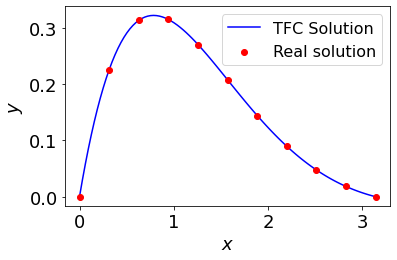

In [4]:
# Calculate the error on the test set
testSet = np.linspace(0,np.pi,101)
error = np.abs(y(testSet,xi)-realSoln(testSet))

# Print out the results
print("Maximum error on test set: " +str(np.max(error)))
print("Mean error on the test set: "+str(np.mean(error)))
print("TFC run time: "+str(time)+" seconds")

# Plot the results
from tfc.utils import MakePlot

# This line is added for Python notebooks but is not necessary in a regular Python script.
%matplotlib inline 

p = MakePlot(r'$x$','$y$')
p.ax[0].scatter(testSet[::10],realSoln(testSet)[::10],color='r',label='Real solution',zorder=3)
p.ax[0].plot(testSet,y(testSet,xi),'b-',label='TFC Solution')
p.ax[0].legend()
p.show()

The TFC estimated solution is within machine level precision of the real solution, and was obtained in just a few milliseconds.